# Highly pathogenic avian influenza case study 

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
from matplotlib.lines import Line2D
from scipy.spatial.distance import pdist, squareform

import gemlib as gl
from gemlib.distributions import (
    ContinuousTimeStateTransitionModel,
)
from gemlib.mcmc.adaptive_hmc import make_initial_running_variance

tfd = tfp.distributions

sns.set_theme()


# Spatial data simulation

## Farm locations

The locations of the farms are centred around 4 centroids. At each of those centroids, we simulate additional premises.

In [3]:
# simulate spatial coordinates - DATA
NUM_VILLAGES = 4
NUM_FARMS_PER_VILLAGE = 80
NUM_FARMS = NUM_VILLAGES * NUM_FARMS_PER_VILLAGE

In [4]:
city_coords = jnp.array(
    [
        [10.0, 10.0, 55.0, 55.0],  # x coords
        [10.0, 55.0, 10.0, 55.0],
    ],
).transpose()

In [5]:
key = jr.key(0)


def sample_farms(city_coord, key):
    # split the key for city and villages
    city_key, sample_key = jr.split(key)
    mean = city_coord

    # spatial dispersion of premises
    scale = jnp.array([10.1, 12.1])

    return (
        mean + jr.normal(sample_key, shape=(NUM_FARMS_PER_VILLAGE, 2)) * scale
    )


# use vmap to apply the sampling function to each city coordinate
keys = jr.split(key, NUM_VILLAGES)  # Split the key for each city
farm_coords = jax.vmap(sample_farms)(city_coords, keys)

# reshape the output to have NUM_OBSERVATIONS rows
farm_coords = farm_coords.reshape(-1, 2)

## Wild bird locations

For the wild bird portion of the data, they are scattered across the grid so we simulate their coordinates uniformly.

In [6]:
wild_bird_key = jr.key(1)

NUM_WILD_BIRD = 80
wild_bird_coords = jr.uniform(
    key=wild_bird_key,
    shape=(NUM_WILD_BIRD, 2),
    minval=jnp.array(0.0),
    maxval=jnp.array(80.0),
)

We can plot the locations of the wild birds and farms.

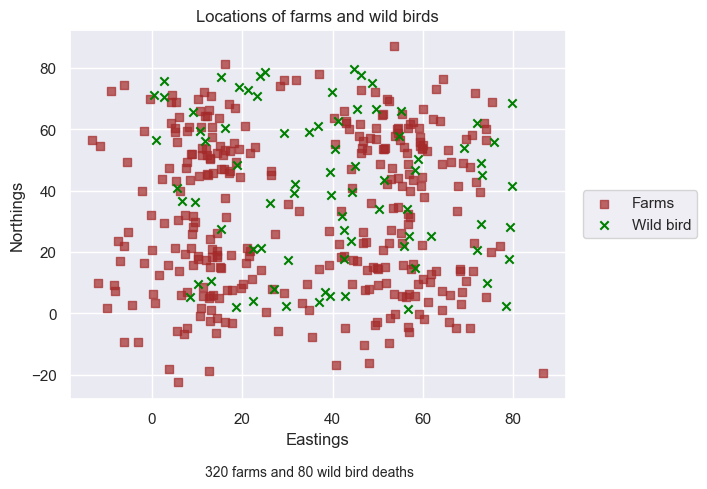

In [7]:
# joint location visualization
plt.scatter(
    farm_coords[:, 0],
    farm_coords[:, 1],
    marker="s",
    color="brown",
    alpha=0.7,
    label="Farms",
)

plt.scatter(
    wild_bird_coords[:, 0],
    wild_bird_coords[:, 1],
    marker="x",
    label="Wild bird",
    color="green",
)

plt.title("Locations of farms and wild birds")
plt.xlabel("Eastings")
plt.ylabel("Northings")
plt.legend(bbox_to_anchor=(1.15, 0.5), loc="center")

txt = f"{NUM_FARMS} farms and {NUM_WILD_BIRD} wild bird deaths"
plt.figtext(
    0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=10
)

plt.show()

## Spatial data preparation

Compute the pairwise distance between the farms since this is needed for the spatial element of the epidemiological model. We use a square form representation since this allows for the use of a matrix multiplication in the transition rates.

In [8]:
def compute_pairwise_distances(unit_locations: jax.Array):
    distances = squareform(pdist(unit_locations))
    return distances.astype("float32")

In [9]:
pairwise_dist = compute_pairwise_distances(farm_coords)

# Epidemiological model

We formally define the model by specifying the transition rate functions and the underlying spatial Gaussian process.

\begin{align}
    \lambda_{j}^{SE}(t) &=  e^{\mu_{f|j} + s_j} +  \beta \sum_{i \in I_t} e^{-\frac{||x_i - x_j||^2}{\phi^2}} \\
    \lambda_j^{EI}(t) &= \eta \\
    \lambda_j^{IR}(t) &= \gamma \\
    SGP &\sim MVN \left( \vec{0}, \Sigma^2 \right) \\
    \Sigma_{ij}^2 &= \mbox{Matern32}(\alpha, l) \\
    y_{i;i\in wb} &\sim \mbox{Binom}(10, \mbox{logit}^{-1}(\mu_{w.b.|i}+ s_i)) \\
\end{align}


In [10]:
incidence_matrix = jnp.array(
    [  # SE  EI IR
        [-1, 0, 0],  # S
        [1, -1, 0],  # E
        [0, 1, -1],  # I
        [0, 0, 1],  # R
    ]
)

In [11]:
def make_initial_state(population_size):
    return jnp.concatenate(
        [  # S  E  I  R
            jnp.array([[0, 0, 1, 0]]),  # initial infected
            jnp.repeat(jnp.array([[1, 0, 0, 0]]), population_size - 1, axis=0),
        ],
        axis=0,
    )


initial_state = make_initial_state(NUM_FARMS)

In [12]:
def spatial_decay(distance, decay_rate):
    return jnp.exp(-(distance**2) / decay_rate)

We assemble the epidemiological model inside a Tensorflow `JointDistributionCoroutine`. The benefit is that we get access to the `sample` and `log_prob` methods since the library builds this up based on the DAG represented in the library. Further detail can be found in [this paper](https://arxiv.org/pdf/2001.11819).

The model specification is meant to closely mimic the associate DAG. As such, the below `hpai_seir_spec` is broadly split into two sections:

1. Gaussian process
2. Compartmental model for the farms

The ecological dataset on wild bird deaths is linked to the compartmental/transmission model through the risk surface generated by the Gaussian process.

In [ ]:
def hpai_seir_spec():
    # Gaussian process
    gp_amplitude = yield tfd.Gamma(
        concentration=np.float64(2.0), rate=np.float64(1.0), name="gp_amplitude"
    )
    gp_length_scale = yield tfd.Gamma(
        concentration=np.float64(16.0),
        rate=np.float64(2.0),
        name="gp_length_scale",
    )
    matern = tfp.math.psd_kernels.MaternThreeHalves(
        amplitude=gp_amplitude,
        length_scale=gp_length_scale,
        name="cov_kernel",
    )
    risk_surface = yield tfd.GaussianProcess(
        kernel=matern,
        index_points=jnp.concat([farm_coords, wild_bird_coords]),
        name="risk_surface",
    )

    # Split risk surface by species
    farm_risk_surface = jnp.asarray(risk_surface[0:NUM_FARMS])
    wb_risk_surface = jnp.asarray(risk_surface[NUM_FARMS:])

    # Wild birds model (generates ecological data)
    wb_mean = yield tfd.Normal(
        loc=np.float64(0.0), scale=np.float64(2.1), name="wb_mean"
    )
    yield tfd.Binomial(
        total_count=10,
        logits=wb_mean + wb_risk_surface,
        name="wild_bird_deaths",
    )

    # Farms model (generates epidemiological data)
    spatial_baseline = yield tfd.Gamma(
        concentration=np.float64(1.0),
        rate=np.float64(2.0),
        name="spatial_baseline",
    )
    spatial_decay_rate = yield tfd.Gamma(
        concentration=np.float64(2.0),
        rate=np.float64(4.0),
        name="spatial_decay_rate",
    )
    farm_wb_exposure = yield tfd.Normal(
        loc=np.float64(0.0), scale=np.float64(2.1), name="farm_wb_exposure"
    )

    def si_rate_fn(_, state):
        farm_farm = spatial_baseline * jnp.matvec(
            spatial_decay(pairwise_dist, spatial_decay_rate), state[:, 2]
        )
        wb_farm = jnp.exp(farm_wb_exposure + farm_risk_surface)
        return farm_farm + wb_farm

    ei_rate = yield tfd.Exponential(rate=np.float64(0.25), name="ei_rate")

    def ei_rate_fn(_0, _1):  # noqa: ARG001
        return ei_rate

    ir_rate = yield tfd.Exponential(rate=np.float64(0.25), name="ir_rate")

    def ir_rate_fn(_0, _1):
        return ir_rate

    yield ContinuousTimeStateTransitionModel(
        incidence_matrix=incidence_matrix,
        initial_state=initial_state,
        transition_rate_fn=[si_rate_fn, ei_rate_fn, ir_rate_fn],
        num_steps=600,
        name="hpai_seir",
    )


hpai_seir_model = tfd.JointDistributionCoroutineAutoBatched(
    hpai_seir_spec, use_vectorized_map=False
)

In [14]:
# preview of the distribution
hpai_seir_model

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  gp_amplitude=[],
  gp_length_scale=[],
  risk_surface=[400],
  wb_mean=[],
  wild_bird_deaths=[80],
  spatial_baseline=[],
  spatial_decay_rate=[],
  farm_wb_exposure=[],
  ei_rate=[],
  ir_rate=[],
  hpai_seir=EventList(time=[600], transition=[600], unit=[600])
) dtype=StructTuple(
  gp_amplitude=float64,
  gp_length_scale=float64,
  risk_surface=float64,
  wb_mean=float64,
  wild_bird_deaths=float64,
  spatial_baseline=float64,
  spatial_decay_rate=float64,
  farm_wb_exposure=float64,
  ei_rate=float64,
  ir_rate=float64,
  hpai_seir=EventList(time=float64, transition=int32, unit=int32)
)>

# Simulation

We can simulate from the model by fixing values for any of the model parameters.

In [15]:
# sample the distribution with fixed parameters
simulation_dists, simulation_result = hpai_seir_model.sample_distributions(
    gp_amplitude=jnp.asarray(0.25),
    gp_length_scale=jnp.array(40.0),
    wb_mean=jnp.array(-0.5),
    spatial_baseline=jnp.array(1.1),
    spatial_decay_rate=jnp.array(5),
    farm_wb_exposure=jnp.array(-7.0),
    ei_rate=jnp.array(0.3),
    ir_rate=jnp.array(0.14),
    seed=jr.key(3),
)

In [ ]:
print(
    f"Avg wild bird prevalence: {jnp.mean(simulation_result.wild_bird_deaths / 10)}"  # noqa: E501
)

Avg wild bird prevalence: 0.35125000000000006


We process infection times to highlight infected premises and compute the final epidemic size (this is mainly done to check if the outcome is realistic).

In [17]:
# Infection event index in time series
infection_index = 2

infection_events = jnp.argwhere(
    simulation_result.hpai_seir.transition == infection_index
)

In [18]:
# Unit ID for who got infected
infected_premises = simulation_result.hpai_seir.unit[infection_events]

In [19]:
# Time infection occured
infected_times = jnp.repeat(
    simulation_result.hpai_seir.time[0],
    farm_coords.shape[0],
)
# Max time - infection time to get colour mapping
infection_colourmap = (
    simulation_result.hpai_seir.time[-1]
    - simulation_result.hpai_seir.time[infection_events],
)

In [ ]:
print(
    f"Number of infected premises: {farm_coords[infected_premises, 1].shape}, Number of non-infected premises: {jnp.delete(farm_coords, infected_premises, axis=0).shape}"  # noqa: E501
)

Number of infected premises: (198, 1), Number of non-infected premises: (122, 2)


## Visualization

In [ ]:
def plot_timeseries(
    times, states, plot_height=4, labels=("S", "E", "I", "R"), alpha=1.0
):
    """Plots multi-state time series data for multiple subpopulations.

    This function generates a matplotlib figure with a separate subplot for each
    subpopulation, showing the progression of the different states (e.g., S, E,
      I, R)
    over time.

    Args:
        times (np.ndarray): Array of time points.
        states (np.ndarray): Array of state values, expected to be shaped
            (time_steps, ..., num_subpopulations, num_states). The second-
            to-last dimension is used to determine the number of subplots.
        plot_height (int, optional): Vertical size of each subplot in inches.
            Defaults to 4.
        labels (list of str, optional): Labels for the states to be used in the
            legend (e.g., "S", "E", "I", "R"). Defaults to ["S", "E", "I", "R"].
        alpha (float, optional): Transparency value for the plot lines.
            Defaults to 1.0.

    Returns:
        tuple: A tuple containing:
            - fig (matplotlib.figure.Figure): The generated matplotlib Figure
            object.
            - ax (np.ndarray of matplotlib.axes.Axes): An array of Axes objects,
              one for each subpopulation.
    """
    num_plots = states.shape[-2]
    fig, ax = plt.subplots(
        1, num_plots, figsize=(num_plots * plot_height * 1.5, plot_height)
    )
    # Ensure ax is an array even for a single subplot
    if num_plots == 1:
        ax = np.array([ax])

    for i in range(num_plots):
        for s, label in enumerate(labels):
            # The transpose handles potentially flexible leading dimensions
            # (e.g., batch_dim)
            state = np.transpose(states[..., i, s])
            ax[i].plot(
                np.transpose(times),
                state,
                label=label,
                color=f"C{s}",
                alpha=alpha,
            )
        ax[i].set_title(f"Subpopulation {i}")
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Individuals")
        # Create dummy lines for a cleaner legend when multiple lines
        # per state are plotted (e.g., in a batch)
        leg_lines = [
            Line2D([0], [0], color=f"C{i}") for i in range(len(labels))
        ]
        ax[i].legend(leg_lines, labels)

    return fig, ax

In [22]:
population_state = jnp.sum(
    simulation_dists.hpai_seir.compute_state(simulation_result.hpai_seir),
    axis=1,
)

/Users/alinmorariu/repos/GitLab/gemlib/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:110: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


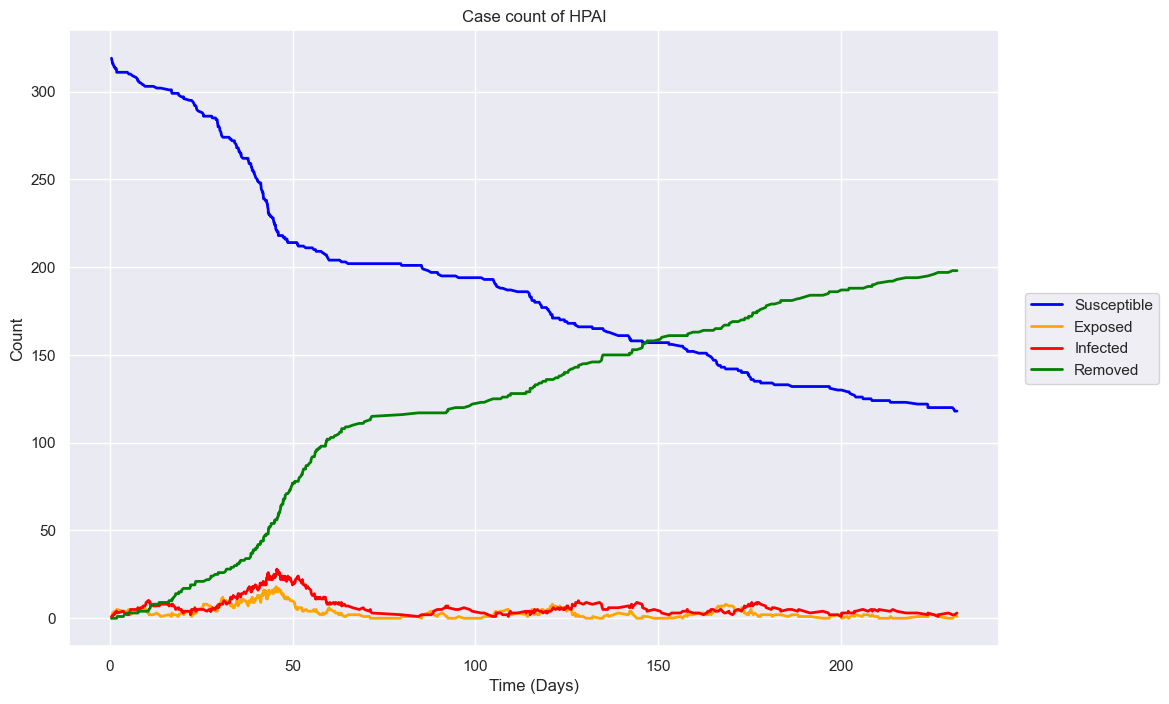

In [23]:
plt.figure(figsize=(12, 8))

# Plot each line with different colors
plt.plot(
    simulation_result.hpai_seir.time,
    population_state[:, 0],
    linewidth=2,
    color="blue",  # Color for "Susceptible"
    label="Susceptible",
)

plt.plot(
    simulation_result.hpai_seir.time,
    population_state[:, 1],
    linewidth=2,
    color="orange",  # Color for "Exposed"
    label="Exposed",
)

plt.plot(
    simulation_result.hpai_seir.time,
    population_state[:, 2],
    linewidth=2,
    color="red",  # Color for "Infected"
    label="Infected",
)

plt.plot(
    simulation_result.hpai_seir.time,
    population_state[:, 3],
    linewidth=2,
    color="green",  # Color for "Removed"
    label="Removed",
)

# Adding titles and labels
plt.title("Case count of HPAI")
plt.xlabel("Time (Days)")
plt.ylabel("Count")

# Legend with adjusted position
plt.legend(bbox_to_anchor=(1.1, 0.5), loc="center")
plt.show()

We now turn our attention to visualizing the GP. Since it is a continuous process, it can be evaluated over the entire grid. We do so by creating a meshgrid of points for which to query the GP.

In [24]:
pred_x = jnp.linspace(-20, 90, 200)
pred_y = jnp.linspace(-20, 90, 200)
X, Y = jnp.meshgrid(pred_x, pred_y)

pred_index_coords = jnp.stack([X.flatten(), Y.flatten()], axis=-1)

In [ ]:
def posterior_pred_dist(elems):
    """Calculates the mean of the posterior predictive distribution for a
     Gaussian Process.

    This function constructs a Gaussian Process Regression Model using a
    Matern 3/2 kernel, conditioned on the provided observations and index points

    It returns the predicted mean at predefined index coordinates.

    Args:
        elems (tuple or list): A sequence of parameters unpacked as
            (ampl, ls, be, s) where:
            - ampl (float or Tensor): The **amplitude** of the Matern3/2 kernel
            - ls (float or Tensor): The **length scale** of the Matern3/2 kernel
            - be: An unused parameter (often a fixed effect estimate).
            - s (Tensor): The **observed values** (data/residuals) to condition
              the GP on.

    Returns:
        Tensor: The mean of the Gaussian Process posterior predictive
        distribution
        at the predefined `pred_index_coords`.
    """
    ampl, ls, be, s = elems

    kernel = tfp.math.psd_kernels.MaternThreeHalves(
        amplitude=ampl,
        length_scale=ls,
        feature_ndims=1,
    )
    dist = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=pred_index_coords,  # Assumed external
        observation_index_points=jnp.concat(
            [farm_coords, wild_bird_coords]
        ),  # Assumed external
        observations=s,  # remove the mean so we just get the random effect
    )

    return dist.mean()

In [26]:
posterior_pred = posterior_pred_dist(
    (
        simulation_result.gp_amplitude,
        simulation_result.gp_length_scale,
        jnp.concat(
            [
                jnp.repeat(simulation_result.wb_mean, NUM_FARMS),
                jnp.repeat(simulation_result.farm_wb_exposure, NUM_WILD_BIRD),
            ],
            axis=0,
        ),
        simulation_result.risk_surface,
    )
)

In [27]:
# reshape the output above to a square
posterior_pred = jnp.reshape(posterior_pred, [1, 200, 200])

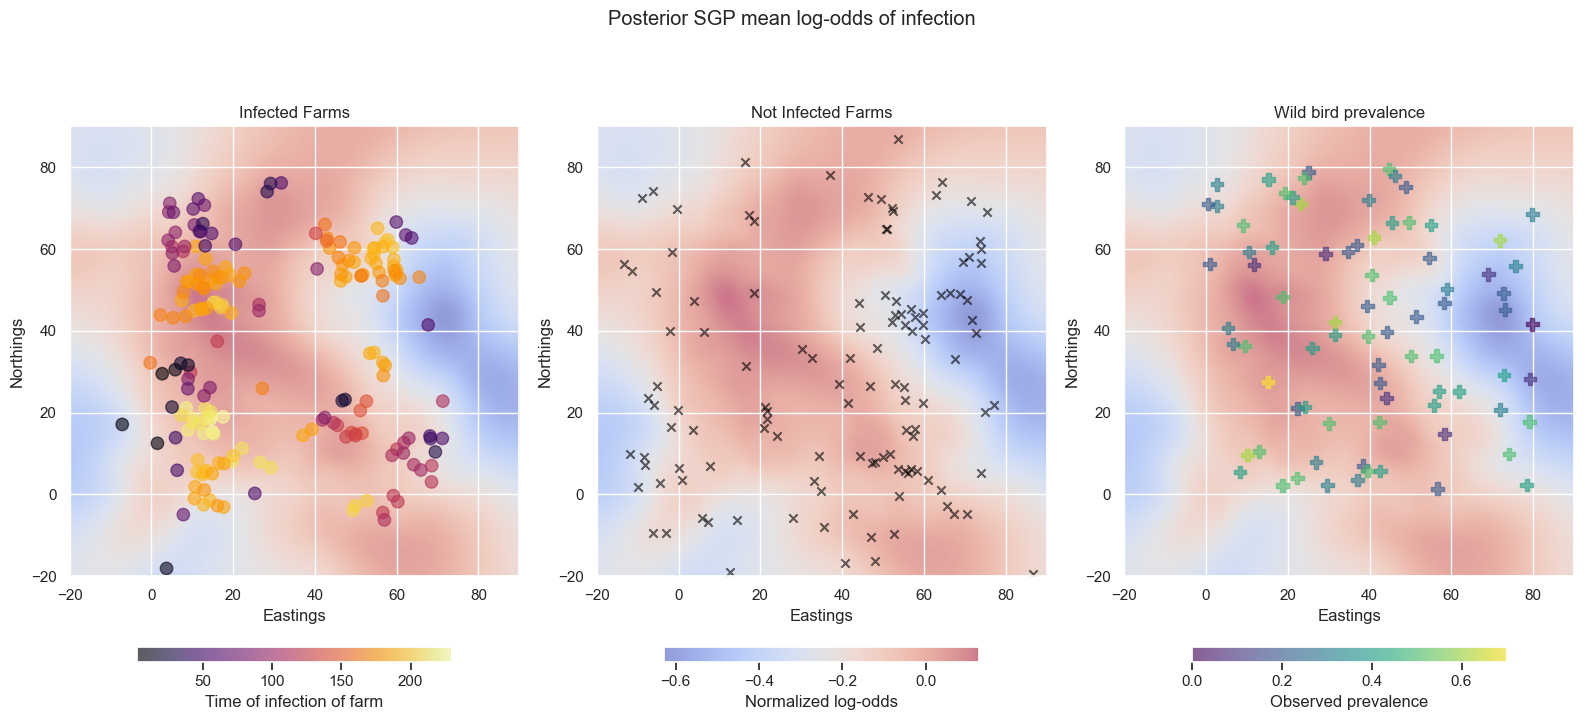

In [ ]:
# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot on the left subplot (inf_farm)
pred_left = axs[0].imshow(
    np.squeeze(np.array(posterior_pred)),
    extent=(-20, 90, -20, 90),
    origin="lower",
    cmap="coolwarm",
    alpha=0.5,
)
inf_farm = axs[0].scatter(
    farm_coords[infected_premises, 0],
    farm_coords[infected_premises, 1],
    marker="o",
    s=80,
    c=infection_colourmap,
    cmap="inferno",
    alpha=0.6,
    label="Infected farms",
)
axs[0].set_title("Infected Farms")
axs[0].set_xlabel("Eastings")
axs[0].set_ylabel("Northings")
axs[0].set_xlim(-20, 90)
axs[0].set_ylim(-20, 90)

# Plot in the middle subplot (other_farm)
pred_mid = axs[1].imshow(
    np.squeeze(np.array(posterior_pred)),
    extent=(-20, 90, -20, 90),
    origin="lower",
    cmap="coolwarm",
    alpha=0.5,
)
other_farm = axs[1].scatter(
    np.delete(farm_coords, infected_premises, axis=0)[:, 0],
    np.delete(farm_coords, infected_premises, axis=0)[:, 1],
    marker="x",
    c="black",
    alpha=0.6,
    label="Not infected farms",
)
axs[1].set_title("Not Infected Farms")
axs[1].set_xlabel("Eastings")
axs[1].set_ylabel("Northings")

# Plot on the right
pred_right = axs[2].imshow(
    np.squeeze(np.array(posterior_pred)),
    extent=(-20, 90, -20, 90),
    origin="lower",
    cmap="coolwarm",
    alpha=0.5,
)

obs_wild = axs[2].scatter(
    wild_bird_coords[:, 0],
    wild_bird_coords[:, 1],
    marker="P",
    s=80,
    alpha=0.6,
    label="Wild bird",
    c=simulation_result.wild_bird_deaths / 10,
    cmap="viridis",
)
axs[2].set_title("Wild bird prevalence")
axs[2].set_xlabel("Eastings")
axs[2].set_ylabel("Northings")

# Add colorbars
fig.colorbar(
    inf_farm,
    ax=axs[0],
    label="Time of infection of farm",
    shrink=0.7,
    pad=0.1,
    location="bottom",
)

fig.colorbar(
    pred_left,
    ax=axs[1],
    label="Normalized log-odds",
    shrink=0.7,
    pad=0.1,
    location="bottom",
)

fig.colorbar(
    obs_wild,
    ax=axs[2],
    label="Observed prevalence",
    shrink=0.7,
    pad=0.1,
    location="bottom",
)

# Set figure title and legend
fig.suptitle("Posterior SGP mean log-odds of infection")
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

plt.tight_layout(rect=[0, 0.03, 1, 1])

# Parameter inference
The inverse problem involves calibrating the model to observed data. Suppose that the we observed the wild bird deaths and case counts seen in `simulation.results.wild_bird_deaths` and `simulation.results.hpai_seir` respectively.

In [29]:
# observed data
wild_bird_deaths = simulation_result.wild_bird_deaths
farm_cases = simulation_result.hpai_seir

We can take advantage of the model defined earlier and condition the probabilistic model on the observed data. This is done using the `experimental_pin` method of the `JointDistributionCoroutine`.

In [30]:
pinned_model = hpai_seir_model.experimental_pin(
    wild_bird_deaths=wild_bird_deaths,
    hpai_seir=farm_cases,
)

In [31]:
# define MCMC state
initial_position = pinned_model.sample_unpinned(seed=jr.key(4))

In [32]:
initial_position

StructTuple(
  gp_amplitude=Array(0.94858998, dtype=float64),
  gp_length_scale=Array(10.58119258, dtype=float64),
  risk_surface=Array([ 4.09782188e-01,  5.84476845e-01,  7.32712525e-01, -1.53852737e+00,
            1.46133967e+00,  6.05152644e-01, -1.57538409e+00,  7.65934478e-01,
            1.31278344e+00, -1.42310796e+00, -1.28046320e+00, -5.81746370e-01,
            9.33319014e-01,  3.06116953e-01,  6.26001537e-01, -2.61007048e+00,
           -1.81170072e-01,  5.47142440e-01, -8.77516978e-01,  6.03500556e-01,
            1.04965082e+00, -1.98932720e+00, -3.46096927e-01,  2.81326106e-01,
            5.45811104e-01, -6.15344063e-01, -1.61899810e+00,  3.18767774e-01,
            3.21952182e-01, -2.04589065e+00, -1.44992235e-01,  1.76891655e-01,
            4.98221233e-01,  1.20008226e+00, -1.29987921e+00, -1.94068491e+00,
           -1.64910681e+00, -1.20998742e-01,  5.51050850e-01,  1.06423901e+00,
           -1.76497757e+00,  5.80244192e-01,  7.54098874e-01,  1.17531663e+00,
     

In [33]:
# define sampler
kernel = gl.mcmc.transform_sampling_algorithm(
    bijectors=[
        tfp.bijectors.Exp(),  # gp_amplitude, need > 0
        tfp.bijectors.Exp(),  # gp_length_scale, need > 0
        tfp.bijectors.Identity(),  # spatial_baseline
        tfp.bijectors.Identity(),  # spatial_decay, need > 0
        tfp.bijectors.Identity(),  # farm_gp_mean
        tfp.bijectors.Identity(),  # wb_gp_mean
        tfp.bijectors.Identity(),  # ei_rate, need > 0
        tfp.bijectors.Identity(),  # ir_rate, need > 0
        tfp.bijectors.Identity(),  # gp
    ],
    sampling_algorithm=gl.mcmc.adaptive_hmc(
        initial_step_size=0.0001,
        num_leapfrog_steps=16,
        num_step_size_adaptation_steps=4000,
        num_mass_matrix_estimation_steps=4000,
        initial_running_variance=make_initial_running_variance(
            [
                initial_position.__getattribute__(var)
                for var in initial_position._fields
            ]
        ),
    ),
)

In [34]:
# create function to run the MCMC sampler
@jax.jit
def run_chain(x0, seed):
    samples, info = gl.mcmc.mcmc(
        num_samples=8000,
        sampling_algorithm=kernel,
        target_density_fn=pinned_model.log_prob,
        initial_position=x0,
        seed=seed,
    )
    return samples, info

In [35]:
# Warning! ~36min run time on Colab CPU
samples_mwg, results_mwg = run_chain(initial_position, seed=jr.key(5))

2025-11-05 15:34:10.484576: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce-window.24 = s64[1,1,4,320,38,16]{2,3,4,1,0,5} reduce-window(%constant.6836, %constant.4060), window={size=1x1x1x1x1x16 pad=0_0x0_0x0_0x0_0x0_0x15_0}, to_apply=%region_5.576.clone.1

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-11-05 15:34:10.812637: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.332819s
Constant folding an instruction is taking > 1s:

  %reduce-window.24 = s64[1,1,4,320,38,16]{2,3,4,1,0,5} reduce-window(%constant.6836, %constant.4060), window={siz

In [36]:
estimated_values = jax.tree_util.tree_map(
    lambda x: jnp.mean(x, axis=0), samples_mwg
)

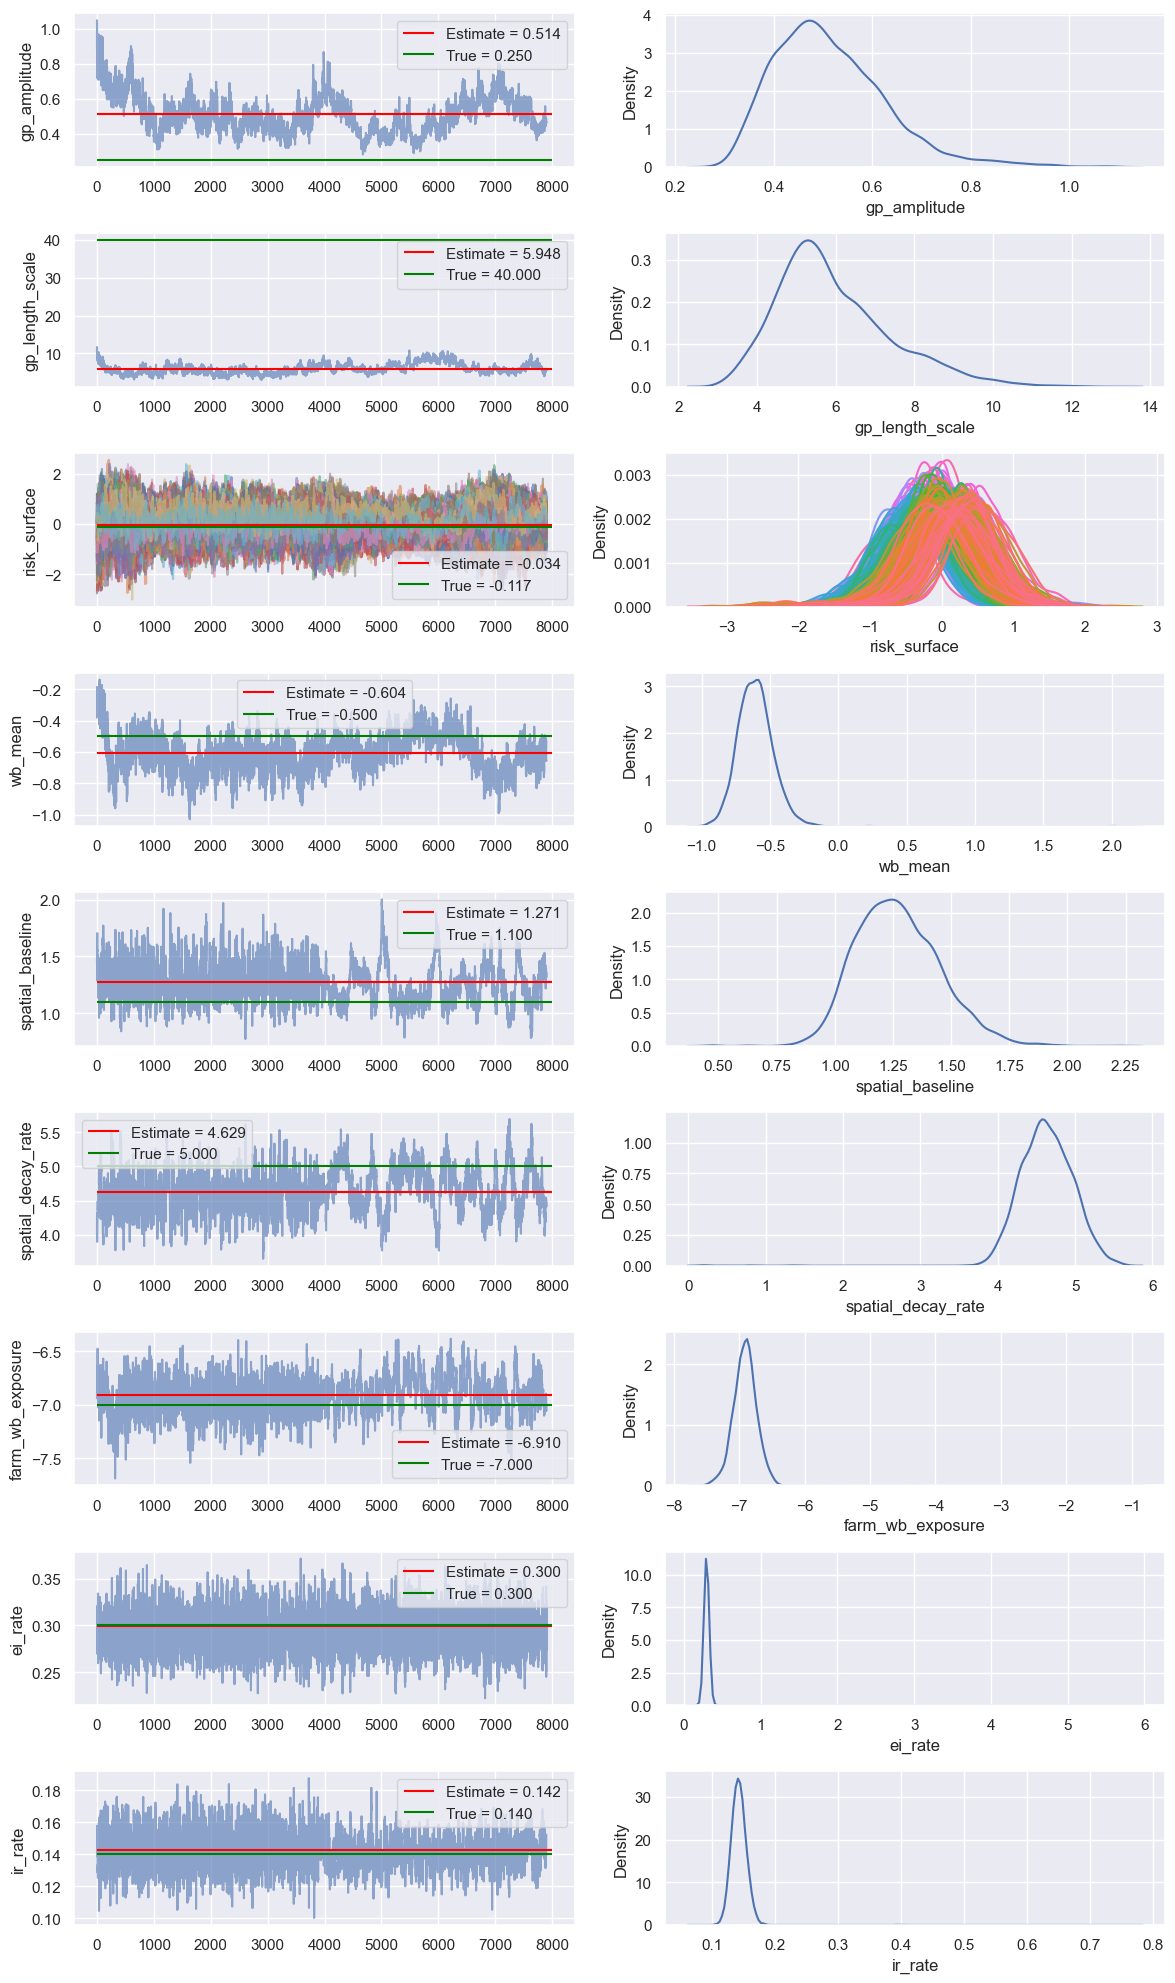

In [ ]:
# Plot the MCMC samples
fig, ax = plt.subplots(
    nrows=len(samples_mwg._fields), ncols=2, figsize=(12, 20)
)

for i, name in enumerate(samples_mwg._fields):
    samp = getattr(samples_mwg, name)
    # trace
    ax[i, 0].plot(samp[100:], alpha=0.6)
    # estimated value
    ax[i, 0].hlines(
        y=jnp.mean(estimated_values[i]),
        xmin=0,
        xmax=8000,
        color="red",
        label=f"Estimate = {jnp.mean(estimated_values[i]):.3f}",
    )
    # true value
    ax[i, 0].hlines(
        y=jnp.mean(simulation_result._asdict().get(name)),
        xmin=0,
        xmax=8000,
        color="green",
        label=f"True = {jnp.mean(simulation_result._asdict().get(name)):.3f}",
    )
    ax[i, 0].set_ylabel(name)
    ax[i, 0].legend()

    sns.kdeplot(samp, ax=ax[i, 1], legend=False)
    ax[i, 1].set_xlabel(name)

fig.tight_layout()